In [1]:
from pyobo.sources.chebi import get_chebi_id_smiles_mapping
import pandas as pd
from indra_cogex.client import Neo4jClient
from rdkit.Chem import PandasTools

INFO: [2024-02-23 11:42:39] rdkit - Enabling RDKit 2023.03.3 jupyter extensions


In [2]:
chebi_smiles = get_chebi_id_smiles_mapping(version="230")
len(chebi_smiles)

184858

In [3]:
client = Neo4jClient()

INFO: [2024-02-23 11:42:40] indra_cogex.client.neo4j_client - Using configured URL for INDRA neo4j connection
INFO: [2024-02-23 11:42:40] indra_cogex.client.neo4j_client - Using configured credentials for INDRA neo4j connection


## Get Genes for Disease

The following query gets all of the genes that are associated with the disease, as a summary. The gene-disease relationships come from a combination of 1) DisGeNet associations and 2) INDRA statements.

Below, we will leverage various ways these are conected to chemicals.

In [4]:
cypher = """\
    MATCH p=(gene:BioEntity)-[r]-(disease:BioEntity)
    WHERE disease.id in ['mesh:D010190', 'doid:1793']
       AND gene.type = 'human_gene_protein'
    RETURN DISTINCT gene.id, gene.name, collect(DISTINCT type(r))
    ORDER BY gene.id
"""

gene_associations = client.query_tx(cypher, )
gene_associations_df = pd.DataFrame(gene_associations, columns=['gene_curie', 'gene_name', "types"])
gene_associations_df.to_csv("genes.tsv", sep='\t', index=False)
gene_associations_df

,gene_curie,gene_name,types
0,hgnc:10019,RIPK1,[indra_rel]
1,hgnc:10020,RIPK2,[indra_rel]
2,hgnc:10021,RIPK3,[indra_rel]
3,hgnc:10046,RNASE3,[indra_rel]
4,hgnc:10069,RNF6,[indra_rel]
...,...,...,...
972,mesh:D009077,Mucins,[indra_rel]
973,mesh:D011451,Prostaglandin-Endoperoxide Synthases,[indra_rel]
974,mesh:D016333,HIV Protease,[indra_rel]
975,mesh:D053668,Syndecan-1,[indra_rel]


## Get Relationships via Gene/Protein Interactions

The following query extends the previous gene query to find all of the chemicals affecting the genes. The chemical-gene relationships primary come from INDRA statements.

In [5]:
# This query gets the genes/chemicals associated with pancreatic cancer
cypher = """\
    MATCH p=(chemical:BioEntity)-[]->(gene:BioEntity)-[]-(disease:BioEntity)
    WHERE disease.id in ['mesh:D010190', 'doid:1793']
       AND gene.type = 'human_gene_protein'
       AND chemical.type = 'small_molecule'
    RETURN chemical.id, chemical.name, count(DISTINCT gene.id) as n_genes
    ORDER BY n_genes DESC
"""

records = client.query_tx(cypher, )
records_df = pd.DataFrame(records, columns=['chemical_curie', 'chemical_name', 'n_unique_genes'])

In [7]:
# Add smiles based on ChEBI lookup
records_df["smiles"] = records_df["chemical_curie"].map(lambda s: chebi_smiles.get(s.strip('chebi:')))

records_df.to_csv("chemical_gene_disease.tsv", sep='\t', index=False)

[11:44:04] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:44:04] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:44:04] Explicit valence for atom # 2 O, 3, is greater than permitted
[11:44:04] Explicit valence for atom # 0 N, 4, is greater than permitted
[11:44:04] Explicit valence for atom # 9 N, 4, is greater than permitted
[11:44:04] WARNING: not removing hydrogen atom without neighbors
[11:44:04] Explicit valence for atom # 9 N, 4, is greater than permitted
[11:44:04] Explicit valence for atom # 9 N, 4, is greater than permitted
[11:44:04] Explicit valence for atom # 34 N, 4, is greater than permitted
[11:44:04] Explicit valence for atom # 7 O, 3, is greater than permitted
[11:44:04] Explicit valence for atom # 1 N, 4, is greater than permitted
[11:44:04] WARNING: not removing hydrogen atom without neighbors
[11:44:04] Conflicting single bond directions around double bond at index 20.
[11:44:04]   BondStereo set to STEREONONE and single bond dir

,chemical_curie,chemical_name,n_unique_genes,smiles,ROMol
0,chebi:33216,bisphenol A,917,CC(C)(C1=CC=C(O)C=C1)C1=CC=C(O)C=C1,
1,chebi:39867,valproic acid,850,CCCC(CCC)C(O)=O,
2,chebi:28119,"2,3,7,8-tetrachlorodibenzodioxine",756,Clc1cc2Oc3cc(Cl)c(Cl)cc3Oc2cc1Cl,
3,chebi:29865,benzo[a]pyrene,751,c1ccc2c(c1)cc1ccc3cccc4ccc2c1c34,
4,chebi:27899,cisplatin,707,[H][N]([H])([H])[Pt](Cl)(Cl)[N]([H])([H])[H],None
...,...,...,...,...,...
15323,chebi:8359,pratensein,1,COc1ccc(cc1O)-c1coc2cc(O)cc(O)c2c1=O,
15326,chebi:580604,(R)-ketamine,1,CN[C@]1(CCCCC1=O)c1ccccc1Cl,
15327,chebi:38963,triazophos,1,CCOP(=S)(OCC)Oc1ncn(n1)-c1ccccc1,
15330,chebi:27909,paraldehyde,1,CC1OC(C)OC(C)O1,

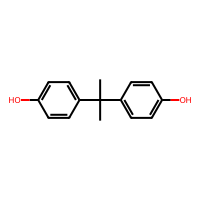
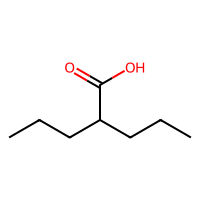
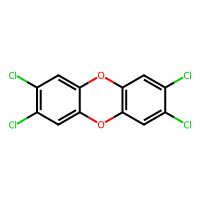
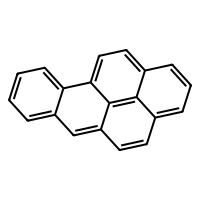
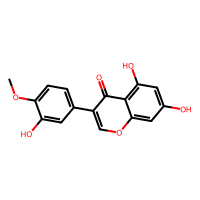
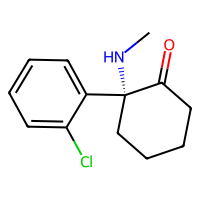
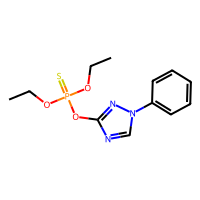
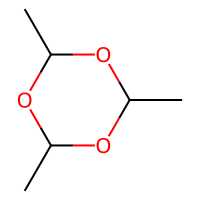
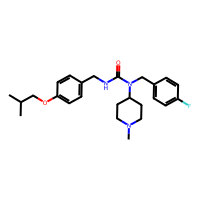

In [8]:
# Remove chemicals without structures
records_df = records_df[records_df["smiles"].notna()]

# Add nice chemical structures
PandasTools.AddMoleculeColumnToFrame(records_df, "smiles")

records_df